In [1]:
%matplotlib inline

from universal import * 

import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import Image
import os
import re

from scipy.special import jn, jn_zeros,j0,j1

## 基本公式
---

### 共振波长
共振辐射波长与Undulator周期$\lambda_U$与电子能量$\gamma$及磁场参数$K$之间的关系为

\begin{equation}
  \lambda_s=\frac{\lambda_U}{2\gamma^2}(1+K^2/2)
\end{equation}

上式变形可得

\begin{equation}
  \gamma=\sqrt{\frac{\lambda_U}{2\lambda_s}(1+K^2/2)}
\end{equation}

### bunching factor

---

根据Govor文章中的推导公式，bunching fator与form factor是同一个概念。无论是定义还是高斯分布所对应的bunching factor，二者都是一致的。

- 定义

\begin{equation}
  F(\omega)=\Bigg|\int_{-\infty}^{\infty} f(t^{\prime})e^{i\omega t^{\prime}}dt^{\prime}\Bigg|^2
\end{equation}

式中，$f(t)$为归一化纵向分布。

对于高斯分布，有$f(t)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\sigma^2/2t^2}$，带入上式可得

\begin{equation}
  F(\omega)=e^{-4\pi^2\sigma^2/\lambda^2}
\end{equation}


## 波荡器辐射
---

单个电子通过波荡器时产生的辐射光谱为[1]
\begin{equation}
  \frac{d^2U_m}{d\Omega d\omega}=\frac{e^2\gamma^2m^2K^2}{4\pi\epsilon_0 c (1+K^2/2)^2}\times\frac{\sin^2(\pi N_u (\omega-\omega_m)/\omega_1)}{ \sin^2(\pi  (\omega-\omega_m)/\omega_1)}\times|JJ|^2
\end{equation}

\begin{equation}
  JJ=J_n\Bigg(\frac{mK^2}{4+2K^2}\Bigg)- J_{n+1}\Bigg(\frac{mK^2}{4+2K^2}\Bigg), m=2n+1
\end{equation}

式中，$U_m$为光场能量，$\Omega$为辐射角，$\omega_1$为基模角频率，$\omega_m=m\omega_1$为$m$次模的角频率，$m=1,3,5,\dots$,$\gamma$为相对论因子，$e$为电子电荷，$\epsilon_0$为真空介电常数，$c$为真空光速，$K$为波荡器参数，$N_u$为波荡器周期数，$J_n$为贝塞尔函数。谱线的宽度与频率有关，满足
\begin{equation}
  \frac{\Delta\omega_m}{\omega_m}=\frac{1}{mN_u}
\end{equation}

辐射角的大小与电子的能量有关，满足
\begin{equation}
  \Delta\Omega_m = \frac{2\pi}{\gamma^2}\frac{1+K^2/2}{2mN_u}
\end{equation}

辐射光的总能量为
\begin{equation}
  U_m(\omega) =\frac{d^2U_m}{d\Omega d\omega} \Delta\Omega_m \Delta\omega_m
\end{equation}

仅考虑基模时，由$N$个电子组成的电子束，辐射光总能量为
\begin{equation}
  U_{\omega}=U_{0 } [N+N(N-1)g^2(\sigma_z)]
\end{equation}

式中，$U_0$为单个电子辐射的光场能量，$\sigma_z$为电子束的均方根长度，$g^2(\sigma_z)=e^{-4\pi^2\sigma_z^2/\lambda^2}$被称为形状因子(form factor)，$\lambda$为辐射光的波长。从$g^2(\sigma_z)$的定义可见，当电子束的长度大于辐射光的波长时，$g^2(\sigma_z)$很小。在这样的情况下，不同纵向位置的电子产生的辐射光相位是不同步的，辐射光的能量等于每个电子所辐射的光场的线性叠加，与电荷量(即$N$)成正比，这被称为非相干辐射。当电子束的长度小于辐射光的波长时，$g^2(\sigma)\rightarrow 1$，因此辐射光的能量正比于电荷量的平方(即$N^2$)，这被称为相干辐射。


## 高增益公式
---

Pierce参数：

\begin{equation}
  \rho = \Bigg[ \frac{K_0^2 [JJ]^2}{32}\frac{k_p^2}{k_u^2}\Bigg]^{1/3} = \Bigg[ \frac{1}{16} \frac{I_e}{I_A} \frac{K_0^2 [JJ]^2}{\gamma_0^3\sigma_x^2k_u^2} \Bigg]^{1/3}
\end{equation}

增益参数$\Gamma$：
\begin{equation}
  \rho = \frac{\Gamma}{2k_u}
\end{equation}

1D增益长度为
\begin{equation}
  L_{g0} = \frac{1}{4\pi\sqrt{3}}\frac{\lambda_u}{\rho}
\end{equation}

高增益FEL中，光场变化方程为
\begin{equation}
  \tilde{E_x(z)}=\frac{E_{in}}{3}\Big[\exp((i+\sqrt{3})\Gamma z/2)+\exp((i-\sqrt{3})\Gamma z/2)+\exp(-i\Gamma z)\Big]
\end{equation}
式中，第一项为指数增长，第二项为阻尼振荡，第三项为振荡。电子束运动一段距离后，指数增长项起主要作用，故有
\begin{equation}
  |\tilde{E_x(z)}|\approx\exp(\sqrt{3}\Gamma z/2)=\frac{E_{in}}{3}\exp(z/(2L_{g0}))
\end{equation}

转化为功率后有
\begin{equation}
  P(z)\approx=\frac{P_{in}}{9}\exp(z/(L_{g0}) \text{ for } z\le2L_{g0}
\end{equation}

## 基本公式

In [3]:
def undulator_parameter(B,lam_u):
    '''
    Parameters
      B: peak magnetic field in nit of Tesla
      lam_u: undulator period in unit of meter
    '''
    return 0.933728997664305*B*lam_u*1e2
def resonant_undulator_parameter(lam_s,lam_u,gamma):
    return np.sqrt(2.*(2*gamma**2*lam_s/lam_u-1))
def resonant_wavelength(K,lam_u,gamma):
    '''K: undulator parameter
    lam_u: undulator period in unit of meter
    gamma: energy in unit of mec2'''
    return lam_u/2./gamma**2*(1+K**2/2)
def resonant_energy(K,lam_u,lam_s):
    '''K: undulator parameter
    lam_u: undulator period
    lam_s: radiation wavelength'''
    return np.sqrt(lam_u/2./lam_s*(1+K**2/2.))
print (resonant_undulator_parameter(0.1e-3,0.032,7.2/g_mec2+1))

0.919983475602291


## Undulator辐射

In [4]:
def JJ2(K,n=0):
    '''K: undulator parameter
    m=2n+1: harmonic number
    
    return [J_n(x)-J_n+1(x)]^2'''
    m=2*n+1
    x=1.0*m*K**2/(4+2*K**2)
    return (jn(n,x)-jn(n+1,x))**2
def ss(Nu,y):
    '''sin^2(Nu*y)/sin^2(y)'''
    if(y==0):
        return Nu**2
    else:
        return np.sin(Nu*y)**2/np.sin(y)**2
def lam2omega(lam):
    return 2*np.pi*g_c/lam

def undulator_radiation(Nu,K,ww,w1,n=0):
    '''
    The spectral energy density per electron of the radiation emittied forward
    direction for the m-th harmonic
    Parameters
      Nu: number of period
      K: undulator parameter
      ww: angular frequency of interest
      w1=2*pi*c/lamda
      m=2n+1: harmonic number
    Returns
      Undulator radiation per frequency per solid angle
    '''
    m=2*n+1
    wm=w1*m
    y=np.pi*(ww-wm)/w1
    
    c1=g_qe**2*gamma**2*m**2*K**2/4.0/np.pi/g_eps0/g_c/(1+K**2/2)**2
    return c1*ss(Nu,y)*JJ2(K,n)

def angular_width(Nu,K,n=0):
    m=2*n+1
    return 2*np.pi/gamma**2/2./m/Nu*(1+K**2/2)

def frac_bandwidth(Nu,w1,n=0):
    m=2*n+1
    wm=w1*m
    return 1.0/m/Nu*wm

def radiation(Nu,K,ww,w1,n=0):
    return undulator_radiation(Nu,K,ww,w1,n)*angular_width(Nu,K,n)*frac_bandwidth(Nu,w1,n)

def form_factor(lam_s=300e-6,sigma_t=100e-15):
    '''lam_s: radiation wavelength, m
    sigma_t: rms bunch length, second'''
    sigma_z=sigma_t*g_c
    return np.exp(-2*np.pi**2*sigma_z**2/lam_s**2)

def radiation_from_bunch(Nu,K,ww,w1,lam_s,sigma_t,Qe=20e-12,n=0):
    Ne=Qe/g_qe
    return radiation(Nu,K,ww,w1,n)*(Ne+Ne*(Ne-1)*form_factor(lam_s,sigma_t)**2)

In [ ]:
workdir='./undulator'
os.chdir(workdir)

In [14]:
Nu, lam_u=5, 10e-2

Ek=20 # MeV
gamma=1+Ek/g_mec2

Qe=68e-12
sigma_z=250e-15/2.355 # fs
lamb=np.linspace(100e-6,500e-6,200)

rr=[]
for i in np.arange(len(lamb)):
    ll=lamb[i]
    w1=2*np.pi*g_c/ll
    ww=w1
    ff=form_factor(ll,sigma_z)**2
    KK=resonant_undulator_parameter(ll,lam_u,gamma)
    nj1=radiation_from_bunch(Nu,KK,ww,w1,ll,sigma_z,Qe)*1e9
    nj2=radiation_from_bunch(Nu,KK,ww,w1,ll,600e-15,Qe)*1e9
    nj3=radiation_from_bunch(Nu,KK,ww,w1,ll,900e-15,Qe)*1e9
    rr.append([ll,nj1,nj2,nj3,ff])
rr=np.array(rr)
## plot
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(5,4))
axes.plot(g_c/rr[:,0]/1e12,rr[:,1],'r-',label=r'FWHM = 250 fs')
#axes.plot(g_c/rr[:,0]/1e12,rr[:,2],'b-',label=r'$\sigma_t$ = 600 fs')
#axes.plot(g_c/rr[:,0]/1e12,rr[:,3],'g-',label=r'$\sigma_t$ = 900 fs')
axes.grid()
#axes.axis([0.5,3,1e-6,1e3])
axes.legend(fontsize = 11)
#axes.set_yscale("log")
axes.set_xlabel(r'radiation frequency (THz)')
axes.set_ylabel(r'radiation energy (nJ)')
#fig.savefig('radiation_energy_68pC.png')

Text(0, 0.5, 'radiation energy (nJ)')

Text(0, 0.5, 'radiation energy (nJ)')

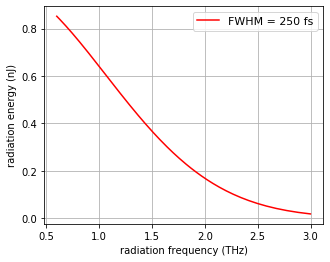

In [13]:
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(5,4))
axes.plot(g_c/rr[:,0]/1e12,rr[:,4],'r-',label=r'FWHM = 250 fs')
#axes.plot(g_c/rr[:,0]/1e12,rr[:,2],'b-',label=r'$\sigma_t$ = 600 fs')
#axes.plot(g_c/rr[:,0]/1e12,rr[:,3],'g-',label=r'$\sigma_t$ = 900 fs')
axes.grid()
#axes.axis([0.5,3,1e-6,1e3])
axes.legend(fontsize = 11)
#axes.set_yscale("log")
axes.set_xlabel(r'radiation frequency (THz)')
axes.set_ylabel(r'radiation energy (nJ)')

In [42]:
### 计算辐射功率谱

Nu,lam_u,B=42,3.8e-2,0.4
gamma=7.2/0.511+1
sigma_t=350e-15/2.355
K=undulator_parameter(B,lam_u)
lam_s=resonant_wavelength(K,lam_u,gamma)
w1=2*np.pi*g_c/lam_s

print str.format('共振波长：%.4e um' % (lam_s*1e6))
print str.format('辐射谱密度：%.4e W/Hz/rad' % undulator_radiation(Nu,K,w1,w1,n=0))
print str.format('单个电子辐射能量：%.4e Joul' % radiation(Nu,K,w1,w1,0))
print str.format('束团辐射功率：%.4e W' % (radiation_from_bunch(Nu,K,w1,w1,lam_s,sigma_t,Qe=90e-12)*54.167e6))

共振波长：1.6748e+02 um
辐射谱密度：1.1427e-31 W/Hz/rad
单个电子辐射能量：2.0176e-23 Joul
束团辐射功率：2.1095e+01 W


## 高增益公式

In [36]:
Alfven=17e3
def pierce_parameter(I,gamma,sigma_x,lam_u,B):
    '''K: undulator parameter
    gamma: energy of electron bunch, mec2
    lam_u: undulator period, meter
    B: magnetic field amplitude, Tesla'''
    K=undulator_parameter(B,lam_u)
    ku=2*np.pi/lam_u
    return (1./16*I/Alfven*K**2*JJ2(K)/gamma**3/sigma_x**2/ku**2)**(1./3)
def gain_length(rho,lam_u):
    '''rho: pierce parameter
    lam_u: undulator period'''
    return lam_u/4./np.pi/np.sqrt(3)/rho

## genesis 1.3

In [6]:
class genesis:
    def __init__(self):
        self.undulator={'aw0':0.9,'xlamd':3.8e-2,'nwig':42,'nsec':1,'xkx':0,'xky':1,'iwityp':0,'awd':0.9}
        self.electron={'npart':8192,'gamma0':20,'delgam':1e-1,'rxbeam':1e-3,'rybeam':1e-3,'emitx':2e-6,'emity':2e-6,'alphax':0,\
                       'alphay':0,'curpeak':1e1,'bunch':0}
        self.radiation={'xlamds':1e-3,'prad0':0,'zrayl':0.5,'zwaist':0}
        self.grid={'ncar':261,'rmax0':9,'dgrid':0,'nscz':1,'nscr':1,'nptr':40}
        self.control={'delz':1,'zstop':0,'nbins':4,'iall':0,'ipseed':-1,'shotnoise':1}
        self.time={'itdp':0,'curlen':1e-3,'zsep':1,'nslice':408,'ntail':-253,'iotail':0}
        self.io={'iphsty':1,'ishsty':1,'ippart':0,'ispart':0,'ipradi':0,'isradi':0,'idump':0,'idmpfld':0,\
                     'idmppar':0,'ffspec':0}
        self.lout={'lout':'1 1 1 1 1 0 1 1 1 1 1'}

    def set_key(self,module,key,value):
        if   module=='undulator':
            self.undulator[key]=value
        elif module=='electron':
            self.electron[key]=value
        elif module=='radiation':
            self.radiation[key]=value
        elif module=='grid':
            self.grid[key]=value
        elif module=='control':
            self.control[key]=value
        elif module=='time':
            self.time[key]=value
        elif module=='io':
            self.io[key]=value
        elif module=='lout':
            self.io[key]=value
    
    def output(self,fname='fel1.in'):
        oo=' $newrun\n'
        for k,v in self.undulator.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+`v`+'\n'
        for k,v in self.electron.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+`v`+'\n'
        for k,v in self.radiation.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+`v`+'\n'
        for k,v in self.grid.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+`v`+'\n'
        for k,v in self.control.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+`v`+'\n'
        for k,v in self.time.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+`v`+'\n'
        for k,v in self.io.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+`v`+'\n'
        for k,v in self.lout.iteritems():
            oo=oo+' '+k.ljust(9)+'= '+v+'\n'
        oo=oo+' $end\n'

        f = file(fname,'w') # open for 'w'riting
        f.write(oo.upper()) # write text to file
        f.close()   # close the file

## genesis 1.3后处理

In [7]:
def reform(arr):
    '''Change invalid number like NaNs into zero'''
    masked=np.ma.masked_invalid(arr)
    for i in np.arange(len(arr)):
        if masked.mask[i]==True:
            arr[i]=0
    return arr
def gen_split(datafile,subdir='./',prefix=''):
    '''input: file to be splitted, each subfilename begins with a prefix
       output: no
    '''
    if subdir != './':
        os.mkdir(subdir)
    data=open(datafile, 'r')
    line=data.readline()
    while True:
        while True:
            if not line:
                break
            match=re.search(r'[*]* output: slice',line)
            if match:
                #print match.group()
                snum=re.search(r'[\d]+',line)
                if snum:
                    t=(float)(snum.group())
                    fname=str.format('%s/%sslice_%05.0f.txt' % (subdir,prefix,t))
                    break
            else:
                line=data.readline()
        if not line:
            break
        subdata=open(fname,'w')
        subdata.write(line)
        while True:
            line=data.readline()
            if not line:
                break
            blank=re.search(r'[*]',line)
            if blank:
                #print blank
                break
            else:
                subdata.write(line)
        subdata.close()
        #break
    data.close()
    return
#gen_split('template.out','slices')
def gen_sum(col=0,workdir='./'):
    '''Collect the col-th collumn of all the files under workdir into a 2D array and return it'''
    rr=[]
    for rt, dirs, files in os.walk(workdir):
        for f in files:
            #print f
            snum=re.match(r'slice_[\d]+.txt',f)
            if snum:
                fname=workdir+os.sep+f
                data=np.genfromtxt(fname,skip_header=6,usecols=(col,col+1),invalid_raise=False,filling_values=0,missing_values=0)
                tmp=reform(data[:,0])
                rr.append(tmp)
    return rr

def complexify_phase(a):
    '''Complexify the phases saved in the 2D array a'''
    m,n=a.shape
    b=np.zeros((m,n),dtype=complex)
    for i in np.arange(m):
        for j in np.arange(n):
            b[i,j]=np.complex(np.cos(a[i,j]),np.sin(a[i,j]))
    return b
def gen2spectrum(phase,amp,N=0):
    '''phase and amp are the phases and amplitudes of the output light sigal.'''
    nt,nz=amp.shape
    if N>nt:
        nt=N
    spectrum=np.zeros((nt,nz))
    phase1=complexify_phase(phase)
    #np.savetxt('phase1.dat',phase1,fmt='%12.4E')
    for i in np.arange(nz):
        signal=np.sqrt(amp[:,i])*phase1[:,i]
        spectrum[:,i]=np.abs(fftshift(fft(signal,nt)))
        spectrum[:,i]=spectrum[:,i]*spectrum[:,i]
    return spectrum

In [ ]:
### 计算不同束长的电子束产生的辐射能量

#workdir='./'
#os.chdir(workdir)

Nu,lam_u,B=42,38e-2,0.4
lam_s=300e-6
K=undulator_parameter(B,lam_u)
w1=lam2omega(lam_s)

E_photon=g_h*g_c/lam_s
print E_photon

Ek=7.2 # MeV
gamma=1+Ek/g_mec2

Qe=25e-12
sigma_t=300e-15 # fs

lam=np.linspace(100e-6,500e-6,200)
rr=[]
for i in np.arange(len(lam)):
    lam_s=lam[i]
    w1=lam2omega(lam_s)
    ww=w1
    ff=form_factor(lam_s,sigma_z)**2
    nj=radiation_from_bunch(Nu,K,ww,w1,sigma_t,Qe)*1e9
    rr.append([lam_s,nj,ff])
rr=np.array(rr)
#np.savetxt('sigma_300fs.dat',rr,fmt='%12.4E')

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes[0].plot(rr[:,0]*1e6,rr[:,1])
axes[1].plot(rr[:,0]*1e6,rr[:,2])



### 计算7次谐波分量的辐射功率谱

    Nu,lam_u,B=42,38e-2,0.4
    lam_s=300e-6
    K=undulator_parameter(B,lam_u)
    w1=lam2omega(lam_s)
    n=3
    wm=w1*(2*n+1)
    
    lam=np.linspace(42,44,501)*1e-6
    rr=[]
    for i in np.arange(501):
        lam_s=lam[i]
        ww=2*np.pi*g_c/lam_s
        E_photon=g_h*wm/2/np.pi
        r1=undulator_radiation(Nu,K,ww,w1,n)/E_photon*wm*1e-3*1e-6
        r2=ss(Nu,np.pi*(ww-wm)/w1)
        r3=JJ2(K,n)
        rr.append([lam_s*1e6,r1,r2,r3])
    rr=np.array(rr)
    #np.savetxt('m7.dat',rr,fmt='%.4E')
    plt.plot(rr[:,0],rr[:,1]*1e6,'+')
    plt.show()

### 形状因子

    xx=np.linspace(30,1000,200)*1e-6
    y1=form_factor(xx,100e-15)**2
    y2=form_factor(xx,300e-15)**2
    y3=form_factor(xx,500e-15)**2
    y4=form_factor(xx,1000e-15)**2
    plt.plot(xx,y1,'r-',xx,y2,'b-',xx,y3,'g-',xx,y4,'y-')
    plt.show()

    xx=np.linspace(100e-15,1000e-15,100)
    yy=form_factor(300e-6,xx)**2
    fig,ax=plt.subplots()
    ax.plot(xx*1e15,yy,'r-+')
    ax.set_yscale("log")
    ax.grid()
    ax.set_xlabel('$\sigma_z$')
    ax.set_ylabel('g$^2(\sigma_z$)')
    #ax.show()